# Classification

In [1]:
import numpy as np
import pylab as plt
import seaborn as sns
from tqdm import tqdm

plt.ion()

## Data Preperation

In [2]:
import pandas as pd
from sklearn.preprocessing import scale
from keras.utils import to_categorical

text_features_df = pd.read_hdf('../data/weebit/weebit.h5', 'text_features_df')
train_features_df = pd.read_hdf('../data/weebit/weebit.h5', 'train_features_df')
test_features_df = pd.read_hdf('../data/weebit/weebit.h5', 'test_features_df')

features_mask = text_features_df.columns.str.startswith('feature_')
y_mask = text_features_df.columns == 'y'
features_y_mask = features_mask | y_mask

X_all = text_features_df.loc[:, features_mask]
y_all = text_features_df['y']
y_all_onehot = to_categorical(y_all)

X_train = train_features_df.loc[:, features_mask]
y_train = train_features_df['y']
y_train_onehot = to_categorical(y_train)

X_test = test_features_df.loc[:, features_mask]
y_test = test_features_df['y']
y_test_onehot = to_categorical(y_test)

X_all = scale(X_all)
X_train = scale(X_train)
X_test = scale(X_test)

Using TensorFlow backend.


## Classical ML

In [3]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV


def train_classification_model(model_class, X_train, y_train, model_params={}, hyperparameters_grid={}):
    
    name = model_class.__name__
    
    if 'kernal' in model_params:
        name += ' ' + model_params['kernel']
    #if model_params:
    #    name += ' ' + str(model_params)
    
    if hyperparameters_grid:
        model = GridSearchCV(model_class(random_state=42, **model_params), hyperparameters_grid)
        # name += ' GridCV'
    else:
        model = model_class(random_state=42, **model_params)
        
    model.fit(X_train, y_train)
    
    
    return name, model


Cs = 10.**np.arange(-4, 5)
    
models = dict([train_classification_model(model_class, X_train, y_train, model_params, hyperparameters_grid)
          for model_class, model_params, hyperparameters_grid in
                                     tqdm([
                                         (LogisticRegressionCV, {},  {}),
                                         (LinearSVC, {}, {'C': Cs}),
                                         (SVC, {'kernel': 'rbf'}, {'C': Cs}),
                                         (SVC, {'kernel': 'poly'}, {'C': Cs}),
                                         (SVC, {'kernel': 'sigmoid'}, {'C': Cs}),
                                         (RandomForestClassifier, {}, {'n_estimators': range(10, 101, 10),
                                                                  'max_features': ['auto', 'sqrt'],
                                                                  'max_depth': range(10, 101, 10)}),
                                        (GradientBoostingClassifier, {}, {}),
                                     ])])

100%|██████████| 7/7 [04:38<00:00, 39.74s/it]


## MLP

In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

n_features = X_train.shape[1]

def train_mlp(units):
    model = Sequential()
    model.add(Dense(units, input_shape=(n_features,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Dense(5, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)))

    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(X_train, y_train_onehot, epochs=30, validation_split=0.1, verbose=0)
    
    return model


models['MLP 16'] = train_mlp(16)
models['MLP 32'] = train_mlp(32)
models['MLP 64'] = train_mlp(64)
models['MLP 128'] = train_mlp(238)

## Evaluation

In [5]:
import itertools
import functools
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

def threshold_socre(y_true, y_pred):
    return np.sum(np.abs(y_true - y_pred) <= 1) / len(y_true)

def f1_score_micro(y_true, y_pred):
    return f1_score(y_true, y_pred, average='micro')


def calc_metrics(model, X_test, y_test):
    if hasattr(model, 'predict_classes'):
        y_pred = model.predict_classes(X_test)
    else:
        y_pred = model.predict(X_test)
               
    return {metrics.__name__: metrics(y_test, y_pred) for metrics in [accuracy_score,
                                                              classification_report,
                                                              confusion_matrix,
                                                              f1_score_micro,
                                                              threshold_socre,
    ]}

evaluation_df = pd.DataFrame({name: calc_metrics(model, X_test, y_test) for name, model in models.items()}).transpose()

In [6]:
evaluation_df = evaluation_df.sort_values('accuracy_score', ascending=False)
evaluation_df[['accuracy_score', 'f1_score_micro', 'threshold_socre']].astype(float).round(4)

,accuracy_score,f1_score_micro,threshold_socre
GradientBoostingClassifier,0.6786,0.6786,0.8984
MLP 32,0.6690,0.6690,0.8997
MLP 64,0.6690,0.6690,0.9011
LinearSVC,0.6580,0.6580,0.8764
LogisticRegressionCV,0.6566,0.6566,0.8887
MLP 128,0.6538,0.6538,0.8956
MLP 16,0.6511,0.6511,0.8874
RandomForestClassifier,0.6497,0.6497,0.8860
SVC,0.5755,0.5755,0.8173


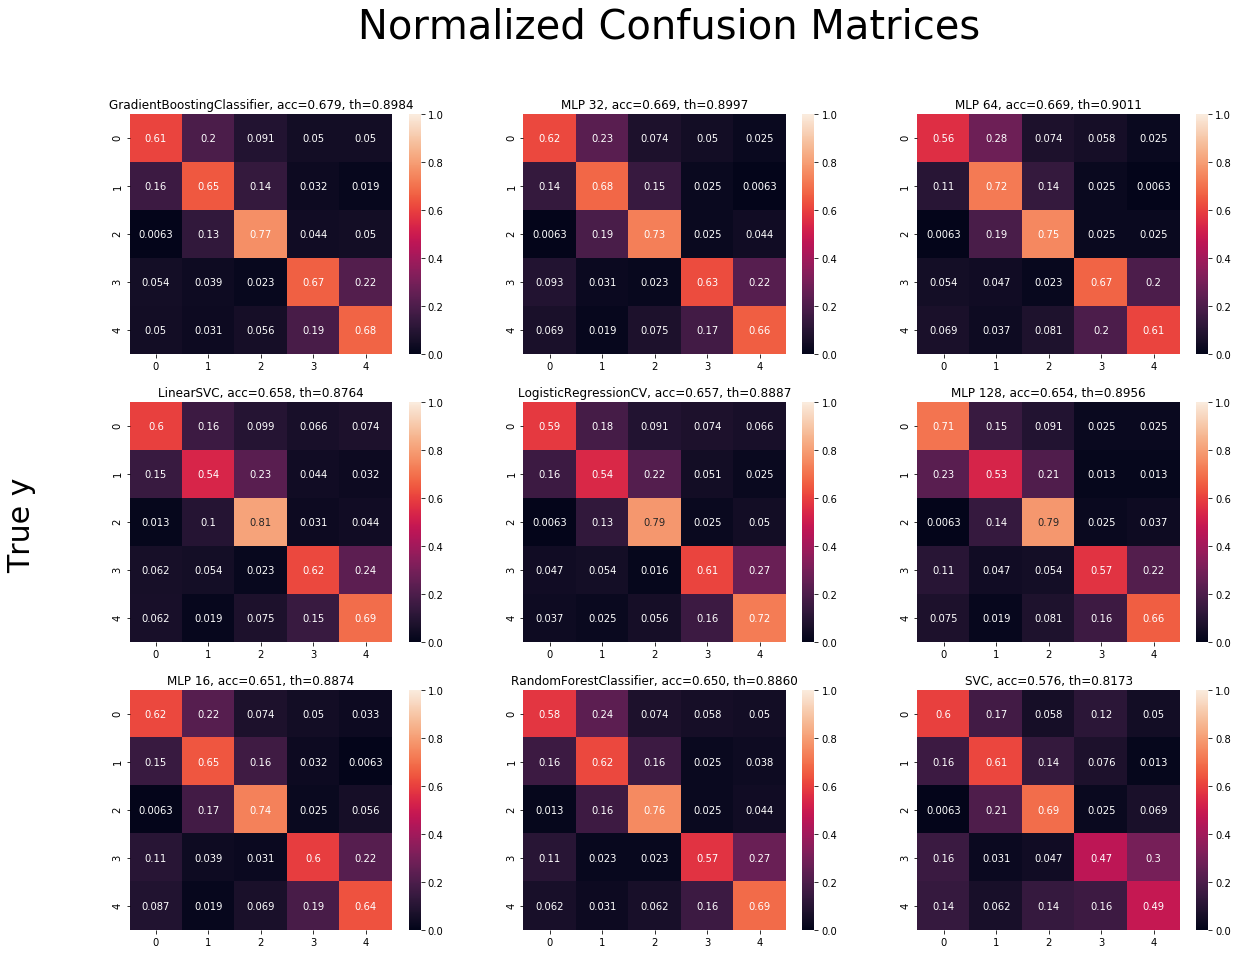

In [7]:
f, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = itertools.chain(*axes)
for (name, r), ax in zip(evaluation_df.iterrows(), axes):
    cm = r['confusion_matrix']
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm, vmin=0, vmax=1, annot=True,
                ax=ax)
    ax.set_title(name + ', acc={:0.3f}, th={:0.4f}'.format(r['accuracy_score'], r['threshold_socre']))

f.text(0.04, 0.5, 'True y', va='center', rotation='vertical', fontsize=30)
f.suptitle('Normalized Confusion Matrices', fontsize=40);